In [18]:
import re
import sys
import numpy as np
import pandas as pd
from time import time
from sklearn import metrics
from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from nltk.stem import PorterStemmer
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_predict, KFold

In [19]:
class Preprocessamento(object):
    def __init__(self):
        self.all_twitter_messages = None
        self.polarity_tweets = None
        self.tweets_stemming = None
        self.palavras = []

    def read_tweets_from_file(self, dataset):
        self.all_twitter_messages = dataset['text'].values

        return self.all_twitter_messages

    def read_polarity_from_file(self, dataset):
        self.polarity_tweets = dataset['class'].values

        return self.polarity_tweets

    def clean_tweets(self, tweet):
        tweet = re.sub('@(\w{1,15})\b', '', tweet)
        tweet = tweet.replace("via ", "")
        tweet = tweet.replace("RT ", "")
        tweet = tweet.lower()

        return tweet

    def clean_url(self, tweet):
        tweet = re.sub(r'(https|http)?://(\w|\.|/|\?|=|&|%)*\b', '', tweet, flags=re.MULTILINE)
        tweet = tweet.replace("http", "")
        tweet = tweet.replace("htt", "")

        return tweet

    def remove_stop_words(self, tweet):
        english_stops = set(stopwords.words('english'))

        words = [i for i in tweet.split() if not i in english_stops]

        return (" ".join(words))

    def stemming_tweets(self, tweet):
        ps = PorterStemmer()

        self.tweets_stemming = ps.stem(tweet)

        return self.tweets_stemming

In [20]:
dataset = pd.read_csv('sentiment.csv')
dataset.head()

,10,"1,26418790706713E+017",2011-10-18 22:06:03,text,class,apple
0,12,"1,26417285559763E+017",2011-10-18 22:00:04,"RT @Jewelz2611 @mashable @apple, iphones r 2 e...",negative,apple
1,13,"1,26416915664085E+017",2011-10-18 21:58:36,"@mashable @apple, iphones r 2 expensive. Most ...",negative,apple
2,14,"1,2641610921268E+017",2011-10-18 21:55:23,THiS IS WHAT WiLL KiLL APPLE http://t.co/72Jw4...,negative,apple
3,20,"1,26411162622497E+017",2011-10-18 21:35:44,@apple why my tunes no go on my iPhone? iPhone...,negative,apple
4,21,"1,26410591949697E+017",2011-10-18 21:33:28,@apple needs to hurry up and release #iTunesMatch,negative,apple


In [21]:
pre = Preprocessamento()

tweets = pre.read_tweets_from_file(dataset)
classes = pre.read_polarity_from_file(dataset)

for i in range(len(tweets)):
    tweets[i] = pre.clean_tweets(tweets[i])
    tweets[i] = pre.clean_url(tweets[i])
    tweets[i] = pre.remove_stop_words(tweets[i])
    #tweets[i] = pre.stemming_tweets(tweets[i])

In [22]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, glove):
        self.glove = glove
        self.gloveweight = None
        self.dim = len(glove.itervalues().next())

    def fit(self, X):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.gloveweight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.glove[w] * self.gloveweight[w]
                         for w in words if w in self.glove] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])


In [23]:
def reading_glove(tweets, dim):
    if dim == 25:
        with open("glove.twitter.27B.25d.txt", "rb") as lines:
            glove = {line.split()[0]: np.array(map(float, line.split()[1:]))
                for line in lines}

    elif dim == 50:
        with open("glove.twitter.27B.50d.txt", "rb") as lines:
            glove = {line.split()[0]: np.array(map(float, line.split()[1:]))
                for line in lines}

    elif dim == 100:
        with open("glove.twitter.27B.100d.txt", "rb") as lines:
            glove = {line.split()[0]: np.array(map(float, line.split()[1:]))
                for line in lines}

    elif dim == 200:
        with open("glove.twitter.27B.200d.txt", "rb") as lines:
            glove = {line.split()[0]: np.array(map(float, line.split()[1:]))
                for line in lines}

    else:
        raise IOError("Dimensão do Word Embedding GloVe incorreta.")

    vec = TfidfEmbeddingVectorizer(glove)
    vec.fit(tweets)
    matrix = vec.transform(tweets)

    return matrix

In [24]:
matrix_embedding = reading_glove(tweets, 25)

In [25]:
matrix_embedding

array([[ 0.74158081, -0.09020527, -0.23958878, ...,  0.41816403,
         0.51970329,  0.54564075],
       [ 0.75250516, -0.10413246, -0.27322124, ...,  0.41866373,
         0.52397909,  0.54214831],
       [ 0.59369938,  0.1585609 ,  0.0125712 , ...,  0.38925703,
         0.3441153 ,  0.1891449 ],
       ...,
       [ 0.80997711,  0.06203335, -0.32969777, ...,  0.18935582,
         0.4486442 ,  0.41699773],
       [ 0.63714674,  0.27908308, -0.53452825, ...,  0.42038817,
         0.36260061,  0.45314085],
       [ 0.81551927,  0.03060585, -0.21039117, ...,  0.40729726,
         0.44257708,  0.3831267 ]])

In [99]:
# Criando modelo Bag-of-Words a partir de features do dataset
vec = CountVectorizer(binary=True)
vec.fit(tweets)
matrix_bow = vec.transform(tweets).toarray()

In [27]:
matrix_bow

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [34]:
# PREDIÇÃO COM MODELO WORD EMBEDDING DE 25 DIMENSÕES
lr = LogisticRegression()

kfold = KFold(n_splits=10, shuffle=True)

resultados = cross_val_predict(lr, matrix_embedding, classes, cv = kfold)

sentimento = ['positive', 'negative', 'neutral']

print("Acurácia...: %.2f" %(metrics.accuracy_score(classes,resultados) * 100))
print("Precision..: %.2f" %(metrics.precision_score(classes,resultados,average='macro') * 100))
print("Recall.....: %.2f" %(metrics.recall_score(classes,resultados, average='macro') * 100))
print("F1-Score...: %.2f" %(metrics.f1_score(classes,resultados, average='macro') * 100))
#print()
print(metrics.classification_report(classes,resultados,sentimento,digits=4))

Acurácia...: 66.91
Precision..: 43.28
Recall.....: 34.26
F1-Score...: 29.36
             precision    recall  f1-score   support

   positive     0.2778    0.0088    0.0170       570
   negative     0.3438    0.0337    0.0614       653
    neutral     0.6767    0.9852    0.8023      2503

avg / total     0.5573    0.6691    0.5523      3726



In [36]:
# PREDIÇÃO COM MODELO WORD EMBEDDING DE 50 DIMENSÕES
matrix_embedding = reading_glove(tweets, 50)

lr = LogisticRegression()

kfold = KFold(n_splits=10, shuffle=True)

resultados = cross_val_predict(lr, matrix_embedding, classes, cv = kfold)

sentimento = ['positive', 'negative', 'neutral']

print("Acurácia...: %.2f" %(metrics.accuracy_score(classes,resultados) * 100))
print("Precision..: %.2f" %(metrics.precision_score(classes,resultados,average='macro') * 100))
print("Recall.....: %.2f" %(metrics.recall_score(classes,resultados, average='macro') * 100))
print("F1-Score...: %.2f" %(metrics.f1_score(classes,resultados, average='macro') * 100))
#print()
print(metrics.classification_report(classes,resultados,sentimento,digits=4))

Acurácia...: 67.39
Precision..: 50.22
Recall.....: 35.36
F1-Score...: 31.52
             precision    recall  f1-score   support

   positive     0.3846    0.0263    0.0493       570
   negative     0.4400    0.0505    0.0907       653
    neutral     0.6819    0.9840    0.8056      2503

avg / total     0.5940    0.6739    0.5646      3726



In [37]:
# PREDIÇÃO COM MODELO WORD EMBEDDING DE 100 DIMENSÕES
matrix_embedding = reading_glove(tweets, 100)

lr = LogisticRegression()

kfold = KFold(n_splits=10, shuffle=True)

resultados = cross_val_predict(lr, matrix_embedding, classes, cv = kfold)

sentimento = ['positive', 'negative', 'neutral']

print("Acurácia...: %.2f" %(metrics.accuracy_score(classes,resultados) * 100))
print("Precision..: %.2f" %(metrics.precision_score(classes,resultados,average='macro') * 100))
print("Recall.....: %.2f" %(metrics.recall_score(classes,resultados, average='macro') * 100))
print("F1-Score...: %.2f" %(metrics.f1_score(classes,resultados, average='macro') * 100))
#print()
print(metrics.classification_report(classes,resultados,sentimento,digits=4))

Acurácia...: 67.55
Precision..: 52.13
Recall.....: 36.19
F1-Score...: 33.15
             precision    recall  f1-score   support

   positive     0.4130    0.0333    0.0617       570
   negative     0.4660    0.0735    0.1270       653
    neutral     0.6849    0.9788    0.8059      2503

avg / total     0.6050    0.6755    0.5731      3726



In [38]:
# PREDIÇÃO COM MODELO WORD EMBEDDING DE 200 DIMENSÕES
matrix_embedding = reading_glove(tweets, 200)

lr = LogisticRegression()

kfold = KFold(n_splits=10, shuffle=True)

resultados = cross_val_predict(lr, matrix_embedding, classes, cv = kfold)

sentimento = ['positive', 'negative', 'neutral']

print("Acurácia...: %.2f" %(metrics.accuracy_score(classes,resultados) * 100))
print("Precision..: %.2f" %(metrics.precision_score(classes,resultados,average='macro') * 100))
print("Recall.....: %.2f" %(metrics.recall_score(classes,resultados, average='macro') * 100))
print("F1-Score...: %.2f" %(metrics.f1_score(classes,resultados, average='macro') * 100))
#print()
print(metrics.classification_report(classes,resultados,sentimento,digits=4))

Acurácia...: 67.79
Precision..: 54.27
Recall.....: 37.07
F1-Score...: 34.73
             precision    recall  f1-score   support

   positive     0.4255    0.0351    0.0648       570
   negative     0.5154    0.1026    0.1711       653
    neutral     0.6872    0.9744    0.8060      2503

avg / total     0.6171    0.6779    0.5814      3726



In [100]:
# PREDIÇÃO COM MODELO BAG-OF-WORDS
lr = LogisticRegression()

kfold = KFold(n_splits=10, shuffle=True)

resultados = cross_val_predict(lr, matrix_bow, classes, cv = kfold)

sentimento = ['positive', 'negative', 'neutral']

print("Acurácia...: %.2f" %(metrics.accuracy_score(classes,resultados) * 100))
print("Precision..: %.2f" %(metrics.precision_score(classes,resultados,average='macro') * 100))
print("Recall.....: %.2f" %(metrics.recall_score(classes,resultados, average='macro') * 100))
print("F1-Score...: %.2f" %(metrics.f1_score(classes,resultados, average='macro') * 100))
#print()
print(metrics.classification_report(classes,resultados,sentimento,digits=4))

Acurácia...: 77.62
Precision..: 74.23
Recall.....: 60.76
F1-Score...: 65.07
             precision    recall  f1-score   support

   positive     0.6636    0.3807    0.4838       570
   negative     0.7746    0.5054    0.6117       653
    neutral     0.7888    0.9369    0.8565      2503

avg / total     0.7671    0.7762    0.7566      3726



In [65]:
lex_positivo = pd.read_csv('opinion_lexicon/positive-words.csv')
lex_negativo = pd.read_csv('opinion_lexicon/negative-words.csv')
lex_positivo = lex_positivo['pos']
lex_negativo = lex_negativo['neg']

In [67]:
lex_positivo.head()

0           a+
1       abound
2      abounds
3    abundance
4     abundant
Name: pos, dtype: object

In [68]:
lex_negativo.head()

0       2-faced
1       2-faces
2      abnormal
3       abolish
4    abominable
Name: neg, dtype: object

In [84]:
len(lex_positivo)+len(lex_negativo)

6789

In [101]:
# PREDIÇÃO COM MODELO BAG-OF-WORDS + WORD EMBEDDING DE 25 DIMENSÕES - UNIGRAM
matrix_embedding = reading_glove(tweets, 25)

lr = LogisticRegression()

kfold = KFold(n_splits=10, shuffle=True)

matrix = np.concatenate((matrix_bow, matrix_embedding), axis=1)

resultados = cross_val_predict(lr, matrix, classes, cv = kfold)

sentimento = ['positive', 'negative', 'neutral']

print("Acurácia...: %.2f" %(metrics.accuracy_score(classes,resultados) * 100))
print("Precision..: %.2f" %(metrics.precision_score(classes,resultados,average='macro') * 100))
print("Recall.....: %.2f" %(metrics.recall_score(classes,resultados, average='macro') * 100))
print("F1-Score...: %.2f" %(metrics.f1_score(classes,resultados, average='macro') * 100))
#print()
print(metrics.classification_report(classes,resultados,sentimento,digits=4))

Acurácia...: 77.43
Precision..: 73.51
Recall.....: 61.21
F1-Score...: 65.25
             precision    recall  f1-score   support

   positive     0.6737    0.3912    0.4950       570
   negative     0.7407    0.5161    0.6083       653
    neutral     0.7908    0.9289    0.8543      2503

avg / total     0.7641    0.7743    0.7562      3726



In [102]:
# PREDIÇÃO COM MODELO BAG-OF-WORDS + WORD EMBEDDING DE 50 DIMENSÕES - UNIGRAM
matrix_embedding = reading_glove(tweets, 50)

lr = LogisticRegression()

kfold = KFold(n_splits=10, shuffle=True)

matrix = np.concatenate((matrix_bow, matrix_embedding), axis=1)

resultados = cross_val_predict(lr, matrix, classes, cv = kfold)

sentimento = ['positive', 'negative', 'neutral']

print("Acurácia...: %.2f" %(metrics.accuracy_score(classes,resultados) * 100))
print("Precision..: %.2f" %(metrics.precision_score(classes,resultados,average='macro') * 100))
print("Recall.....: %.2f" %(metrics.recall_score(classes,resultados, average='macro') * 100))
print("F1-Score...: %.2f" %(metrics.f1_score(classes,resultados, average='macro') * 100))
#print()
print(metrics.classification_report(classes,resultados,sentimento,digits=4))

Acurácia...: 76.76
Precision..: 72.09
Recall.....: 59.95
F1-Score...: 63.85
             precision    recall  f1-score   support

   positive     0.6398    0.3614    0.4619       570
   negative     0.7367    0.5100    0.6027       653
    neutral     0.7862    0.9273    0.8510      2503

avg / total     0.7552    0.7676    0.7479      3726



In [104]:
# PREDIÇÃO COM MODELO BAG-OF-WORDS + WORD EMBEDDING DE 100 DIMENSÕES - UNIGRAM
matrix_embedding = reading_glove(tweets, 100)

lr = LogisticRegression()

kfold = KFold(n_splits=10, shuffle=True)

matrix = np.concatenate((matrix_bow, matrix_embedding), axis=1)

resultados = cross_val_predict(lr, matrix, classes, cv = kfold)

sentimento = ['positive', 'negative', 'neutral']

print("Acurácia...: %.2f" %(metrics.accuracy_score(classes,resultados) * 100))
print("Precision..: %.2f" %(metrics.precision_score(classes,resultados,average='macro') * 100))
print("Recall.....: %.2f" %(metrics.recall_score(classes,resultados, average='macro') * 100))
print("F1-Score...: %.2f" %(metrics.f1_score(classes,resultados, average='macro') * 100))
#print()
print(metrics.classification_report(classes,resultados,sentimento,digits=4))

Acurácia...: 77.48
Precision..: 73.78
Recall.....: 60.87
F1-Score...: 65.04
             precision    recall  f1-score   support

   positive     0.6860    0.3947    0.5011       570
   negative     0.7370    0.4977    0.5941       653
    neutral     0.7903    0.9337    0.8560      2503

avg / total     0.7650    0.7748    0.7558      3726



In [105]:
# PREDIÇÃO COM MODELO BAG-OF-WORDS + WORD EMBEDDING DE 200 DIMENSÕES - UNIGRAM
matrix_embedding = reading_glove(tweets, 200)

lr = LogisticRegression()

kfold = KFold(n_splits=10, shuffle=True)

matrix = np.concatenate((matrix_bow, matrix_embedding), axis=1)

resultados = cross_val_predict(lr, matrix, classes, cv = kfold)

sentimento = ['positive', 'negative', 'neutral']

print("Acurácia...: %.2f" %(metrics.accuracy_score(classes,resultados) * 100))
print("Precision..: %.2f" %(metrics.precision_score(classes,resultados,average='macro') * 100))
print("Recall.....: %.2f" %(metrics.recall_score(classes,resultados, average='macro') * 100))
print("F1-Score...: %.2f" %(metrics.f1_score(classes,resultados, average='macro') * 100))
#print()
print(metrics.classification_report(classes,resultados,sentimento,digits=4))

Acurácia...: 77.62
Precision..: 73.94
Recall.....: 61.66
F1-Score...: 65.79
             precision    recall  f1-score   support

   positive     0.6705    0.4140    0.5119       570
   negative     0.7557    0.5069    0.6068       653
    neutral     0.7919    0.9289    0.8549      2503

avg / total     0.7670    0.7762    0.7590      3726



In [103]:
class Gram(object):
    def __init__(self):
        self.bigram = None
        self.trigram = None
        
    def create_bigram(self, tweet):
        self.bigram = []
        
        for i in range(len(tweet)-1):
            b_gram = tweet[i] + "_" + tweet[i+1]
            self.bigram.append(b_gram)
            
        return (" ".join(self.bigram))

In [117]:
gram = Gram()

tweets_bigram = []

for i in range(len(tweets)):
    tweets_bigram.append(gram.create_bigram(tweets[i].split()))

In [120]:
tweets_uni_big = tweets + tweets_bigram
tweets_uni_big[0]
len(tweets_uni_big)

3726

In [121]:
def count_vectorizer(tweets):
    # Criando modelo Bag-of-Words a partir de features do dataset
    cv = CountVectorizer(binary=True)
    cv.fit(tweets)
    matrix = cv.transform(tweets).toarray()
    
    return matrix

In [122]:
matrix_bow_big = count_vectorizer(tweets_bigram)
matrix_bow_uni_big = count_vectorizer(tweets_uni_big)

In [123]:
# PREDIÇÃO COM MODELO BAG-OF-WORDS - BIGRAM
lr = LogisticRegression()

kfold = KFold(n_splits=10, shuffle=True)

resultados = cross_val_predict(lr, matrix_bow_big, classes, cv = kfold)

sentimento = ['positive', 'negative', 'neutral']

print("Acurácia...: %.2f" %(metrics.accuracy_score(classes,resultados) * 100))
print("Precision..: %.2f" %(metrics.precision_score(classes,resultados,average='macro') * 100))
print("Recall.....: %.2f" %(metrics.recall_score(classes,resultados, average='macro') * 100))
print("F1-Score...: %.2f" %(metrics.f1_score(classes,resultados, average='macro') * 100))
#print()
print(metrics.classification_report(classes,resultados,sentimento,digits=4))

Acurácia...: 75.17
Precision..: 74.40
Recall.....: 53.88
F1-Score...: 58.49
             precision    recall  f1-score   support

   positive     0.7292    0.3070    0.4321       570
   negative     0.7492    0.3522    0.4792       653
    neutral     0.7537    0.9573    0.8434      2503

avg / total     0.7492    0.7517    0.7166      3726



In [124]:
# PREDIÇÃO COM MODELO BAG-OF-WORDS - UNIGRAM + BIGRAM
lr = LogisticRegression()

kfold = KFold(n_splits=10, shuffle=True)

resultados = cross_val_predict(lr, matrix_bow_uni_big, classes, cv = kfold)

sentimento = ['positive', 'negative', 'neutral']

print("Acurácia...: %.2f" %(metrics.accuracy_score(classes,resultados) * 100))
print("Precision..: %.2f" %(metrics.precision_score(classes,resultados,average='macro') * 100))
print("Recall.....: %.2f" %(metrics.recall_score(classes,resultados, average='macro') * 100))
print("F1-Score...: %.2f" %(metrics.f1_score(classes,resultados, average='macro') * 100))
#print()
print(metrics.classification_report(classes,resultados,sentimento,digits=4))

Acurácia...: 77.59
Precision..: 75.26
Recall.....: 60.37
F1-Score...: 64.93
             precision    recall  f1-score   support

   positive     0.7115    0.3807    0.4960       570
   negative     0.7619    0.4900    0.5965       653
    neutral     0.7844    0.9405    0.8554      2503

avg / total     0.7693    0.7759    0.7550      3726



In [126]:
# PREDIÇÃO COM MODELO BAG-OF-WORDS + WORD EMBEDDING DE 25 DIMENSÕES - UNIGRAM + BIGRAM
matrix_embedding = reading_glove(tweets, 25)

lr = LogisticRegression()

kfold = KFold(n_splits=10, shuffle=True)

matrix = np.concatenate((matrix_bow_uni_big, matrix_embedding), axis=1)

resultados = cross_val_predict(lr, matrix, classes, cv = kfold)

sentimento = ['positive', 'negative', 'neutral']

print("Acurácia...: %.2f" %(metrics.accuracy_score(classes,resultados) * 100))
print("Precision..: %.2f" %(metrics.precision_score(classes,resultados,average='macro') * 100))
print("Recall.....: %.2f" %(metrics.recall_score(classes,resultados, average='macro') * 100))
print("F1-Score...: %.2f" %(metrics.f1_score(classes,resultados, average='macro') * 100))
#print()
print(metrics.classification_report(classes,resultados,sentimento,digits=4))

Acurácia...: 77.59
Precision..: 75.44
Recall.....: 60.22
F1-Score...: 64.82
             precision    recall  f1-score   support

   positive     0.7176    0.3789    0.4960       570
   negative     0.7620    0.4855    0.5931       653
    neutral     0.7836    0.9421    0.8556      2503

avg / total     0.7698    0.7759    0.7546      3726



In [127]:
# PREDIÇÃO COM MODELO BAG-OF-WORDS + WORD EMBEDDING DE 50 DIMENSÕES - UNIGRAM + BIGRAM
matrix_embedding = reading_glove(tweets, 50)

lr = LogisticRegression()

kfold = KFold(n_splits=10, shuffle=True)

matrix = np.concatenate((matrix_bow_uni_big, matrix_embedding), axis=1)

resultados = cross_val_predict(lr, matrix, classes, cv = kfold)

sentimento = ['positive', 'negative', 'neutral']

print("Acurácia...: %.2f" %(metrics.accuracy_score(classes,resultados) * 100))
print("Precision..: %.2f" %(metrics.precision_score(classes,resultados,average='macro') * 100))
print("Recall.....: %.2f" %(metrics.recall_score(classes,resultados, average='macro') * 100))
print("F1-Score...: %.2f" %(metrics.f1_score(classes,resultados, average='macro') * 100))
#print()
print(metrics.classification_report(classes,resultados,sentimento,digits=4))

Acurácia...: 78.02
Precision..: 75.88
Recall.....: 61.20
F1-Score...: 65.82
             precision    recall  f1-score   support

   positive     0.7169    0.4088    0.5207       570
   negative     0.7713    0.4855    0.5959       653
    neutral     0.7883    0.9417    0.8582      2503

avg / total     0.7744    0.7802    0.7606      3726



In [128]:
# PREDIÇÃO COM MODELO BAG-OF-WORDS + WORD EMBEDDING DE 100 DIMENSÕES - UNIGRAM + BIGRAM
matrix_embedding = reading_glove(tweets, 100)

lr = LogisticRegression()

kfold = KFold(n_splits=10, shuffle=True)

matrix = np.concatenate((matrix_bow_uni_big, matrix_embedding), axis=1)

resultados = cross_val_predict(lr, matrix, classes, cv = kfold)

sentimento = ['positive', 'negative', 'neutral']

print("Acurácia...: %.2f" %(metrics.accuracy_score(classes,resultados) * 100))
print("Precision..: %.2f" %(metrics.precision_score(classes,resultados,average='macro') * 100))
print("Recall.....: %.2f" %(metrics.recall_score(classes,resultados, average='macro') * 100))
print("F1-Score...: %.2f" %(metrics.f1_score(classes,resultados, average='macro') * 100))
#print()
print(metrics.classification_report(classes,resultados,sentimento,digits=4))

Acurácia...: 77.94
Precision..: 75.74
Recall.....: 60.79
F1-Score...: 65.43
             precision    recall  f1-score   support

   positive     0.7000    0.3930    0.5034       570
   negative     0.7852    0.4870    0.6011       653
    neutral     0.7871    0.9437    0.8583      2503

avg / total     0.7734    0.7794    0.7589      3726



In [129]:
# PREDIÇÃO COM MODELO BAG-OF-WORDS + WORD EMBEDDING DE 200 DIMENSÕES - UNIGRAM + BIGRAM
matrix_embedding = reading_glove(tweets, 200)

lr = LogisticRegression()

kfold = KFold(n_splits=10, shuffle=True)

matrix = np.concatenate((matrix_bow_uni_big, matrix_embedding), axis=1)

resultados = cross_val_predict(lr, matrix, classes, cv = kfold)

sentimento = ['positive', 'negative', 'neutral']

print("Acurácia...: %.2f" %(metrics.accuracy_score(classes,resultados) * 100))
print("Precision..: %.2f" %(metrics.precision_score(classes,resultados,average='macro') * 100))
print("Recall.....: %.2f" %(metrics.recall_score(classes,resultados, average='macro') * 100))
print("F1-Score...: %.2f" %(metrics.f1_score(classes,resultados, average='macro') * 100))
#print()
print(metrics.classification_report(classes,resultados,sentimento,digits=4))

Acurácia...: 78.34
Precision..: 76.16
Recall.....: 61.91
F1-Score...: 66.50
             precision    recall  f1-score   support

   positive     0.7333    0.4246    0.5378       570
   negative     0.7589    0.4916    0.5967       653
    neutral     0.7925    0.9413    0.8605      2503

avg / total     0.7775    0.7834    0.7649      3726



In [161]:
lex_file = open('lex.txt', 'r')
lexicon = lex_file.read().splitlines()
lex_file.close()
lexicon[:5]

['0.00000 0.00000 1.00000',
 '0.00000 0.00000 1.00000',
 '0.00000 1.00000 0.00000',
 '0.00000 1.00000 0.00000',
 '0.00000 0.00000 1.00000']

In [159]:
lista = lexicon[0].split()
lista = map(float, lista)
lista

[0.0, 0.0, 1.0]

In [163]:
matrix_lex = []

for i in range(len(lexicon)):
    vec = lexicon[i].split()
    vec = map(float, vec)
    matrix_lex.append(vec)

In [165]:
matrix_lex[:5]

[[0.0, 0.0, 1.0],
 [0.0, 0.0, 1.0],
 [0.0, 1.0, 0.0],
 [0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0]]

In [168]:
# PREDIÇÃO COM MODELO BAG-OF-WORDS + DICIONÁRIO LÉXICO - UNIGRAM + BIGRAM
lr = LogisticRegression(C=10.0)

kfold = KFold(n_splits=10, shuffle=True)

matrix = np.concatenate((matrix_bow_uni_big, matrix_lex), axis=1)

resultados = cross_val_predict(lr, matrix, classes, cv = kfold)

sentimento = ['positive', 'negative', 'neutral']

print("Acurácia...: %.2f" %(metrics.accuracy_score(classes,resultados) * 100))
print("Precision..: %.2f" %(metrics.precision_score(classes,resultados,average='macro') * 100))
print("Recall.....: %.2f" %(metrics.recall_score(classes,resultados, average='macro') * 100))
print("F1-Score...: %.2f" %(metrics.f1_score(classes,resultados, average='macro') * 100))
#print()
print(metrics.classification_report(classes,resultados,sentimento,digits=4))

Acurácia...: 78.77
Precision..: 73.69
Recall.....: 65.66
F1-Score...: 68.81
             precision    recall  f1-score   support

   positive     0.6464    0.4842    0.5537       570
   negative     0.7480    0.5727    0.6487       653
    neutral     0.8164    0.9129    0.8619      2503

avg / total     0.7784    0.7877    0.7774      3726



In [170]:
# PREDIÇÃO COM MODELO BAG-OF-WORDS + LÉXICO + WORD EMBEDDING DE 25 DIMENSÕES - UNIGRAM + BIGRAM
matrix_embedding = reading_glove(tweets, 25)

lr = LogisticRegression()

kfold = KFold(n_splits=10, shuffle=True)

matrix = np.concatenate((matrix_bow_uni_big, matrix_embedding, matrix_lex), axis=1)

resultados = cross_val_predict(lr, matrix, classes, cv = kfold)

sentimento = ['positive', 'negative', 'neutral']

print("Acurácia...: %.2f" %(metrics.accuracy_score(classes,resultados) * 100))
print("Precision..: %.2f" %(metrics.precision_score(classes,resultados,average='macro') * 100))
print("Recall.....: %.2f" %(metrics.recall_score(classes,resultados, average='macro') * 100))
print("F1-Score...: %.2f" %(metrics.f1_score(classes,resultados, average='macro') * 100))
#print()
print(metrics.classification_report(classes,resultados,sentimento,digits=4))

Acurácia...: 78.56
Precision..: 74.53
Recall.....: 63.36
F1-Score...: 67.25
             precision    recall  f1-score   support

   positive     0.6893    0.4281    0.5281       570
   negative     0.7421    0.5421    0.6265       653
    neutral     0.8045    0.9305    0.8629      2503

avg / total     0.7759    0.7856    0.7703      3726



In [171]:
# PREDIÇÃO COM MODELO BAG-OF-WORDS + LÉXICO + WORD EMBEDDING DE 50 DIMENSÕES - UNIGRAM + BIGRAM
matrix_embedding = reading_glove(tweets, 50)

lr = LogisticRegression()

kfold = KFold(n_splits=10, shuffle=True)

matrix = np.concatenate((matrix_bow_uni_big, matrix_embedding, matrix_lex), axis=1)

resultados = cross_val_predict(lr, matrix, classes, cv = kfold)

sentimento = ['positive', 'negative', 'neutral']

print("Acurácia...: %.2f" %(metrics.accuracy_score(classes,resultados) * 100))
print("Precision..: %.2f" %(metrics.precision_score(classes,resultados,average='macro') * 100))
print("Recall.....: %.2f" %(metrics.recall_score(classes,resultados, average='macro') * 100))
print("F1-Score...: %.2f" %(metrics.f1_score(classes,resultados, average='macro') * 100))
#print()
print(metrics.classification_report(classes,resultados,sentimento,digits=4))

Acurácia...: 78.77
Precision..: 75.17
Recall.....: 63.68
F1-Score...: 67.66
             precision    recall  f1-score   support

   positive     0.7003    0.4263    0.5300       570
   negative     0.7505    0.5528    0.6367       653
    neutral     0.8043    0.9313    0.8632      2503

avg / total     0.7790    0.7877    0.7725      3726



In [172]:
# PREDIÇÃO COM MODELO BAG-OF-WORDS + LÉXICO + WORD EMBEDDING DE 100 DIMENSÕES - UNIGRAM + BIGRAM
matrix_embedding = reading_glove(tweets, 100)

lr = LogisticRegression()

kfold = KFold(n_splits=10, shuffle=True)

matrix = np.concatenate((matrix_bow_uni_big, matrix_embedding, matrix_lex), axis=1)

resultados = cross_val_predict(lr, matrix, classes, cv = kfold)

sentimento = ['positive', 'negative', 'neutral']

print("Acurácia...: %.2f" %(metrics.accuracy_score(classes,resultados) * 100))
print("Precision..: %.2f" %(metrics.precision_score(classes,resultados,average='macro') * 100))
print("Recall.....: %.2f" %(metrics.recall_score(classes,resultados, average='macro') * 100))
print("F1-Score...: %.2f" %(metrics.f1_score(classes,resultados, average='macro') * 100))
#print()
print(metrics.classification_report(classes,resultados,sentimento,digits=4))

Acurácia...: 79.15
Precision..: 75.83
Recall.....: 64.15
F1-Score...: 68.26
             precision    recall  f1-score   support

   positive     0.6975    0.4491    0.5464       570
   negative     0.7707    0.5406    0.6355       653
    neutral     0.8066    0.9349    0.8660      2503

avg / total     0.7836    0.7915    0.7767      3726



In [173]:
# PREDIÇÃO COM MODELO BAG-OF-WORDS + LÉXICO + WORD EMBEDDING DE 200 DIMENSÕES - UNIGRAM + BIGRAM
matrix_embedding = reading_glove(tweets, 200)

lr = LogisticRegression()

kfold = KFold(n_splits=10, shuffle=True)

matrix = np.concatenate((matrix_bow_uni_big, matrix_embedding, matrix_lex), axis=1)

resultados = cross_val_predict(lr, matrix, classes, cv = kfold)

sentimento = ['positive', 'negative', 'neutral']

print("Acurácia...: %.2f" %(metrics.accuracy_score(classes,resultados) * 100))
print("Precision..: %.2f" %(metrics.precision_score(classes,resultados,average='macro') * 100))
print("Recall.....: %.2f" %(metrics.recall_score(classes,resultados, average='macro') * 100))
print("F1-Score...: %.2f" %(metrics.f1_score(classes,resultados, average='macro') * 100))
#print()
print(metrics.classification_report(classes,resultados,sentimento,digits=4))

Acurácia...: 79.36
Precision..: 75.82
Recall.....: 64.89
F1-Score...: 68.85
             precision    recall  f1-score   support

   positive     0.6919    0.4649    0.5561       570
   negative     0.7720    0.5498    0.6422       653
    neutral     0.8106    0.9321    0.8671      2503

avg / total     0.7857    0.7936    0.7801      3726



In [180]:
lex_positivo = list(lex_positivo)
lex_negativo = list(lex_negativo)

In [186]:
cv2 = CountVectorizer(vocabulary=set(lex_positivo+lex_negativo), binary=True)
cv2.fit(tweets_uni_big)
bow_lex = cv2.transform(tweets_uni_big).toarray()

In [187]:
bow_lex.shape

(3726, 6786)

In [1]:
acuracia = [78.56, 78.77, 79.15, 79.36]
precisao = [74.53, 75.17, 75.83, 75.82]
recall = [63.36, 63.68, 64.15, 64.89]
f1 = [67.25, 67.66, 68.26, 68.85]
dimensoes = [25, 50, 100, 200]

In [2]:
import matplotlib.pyplot as plt

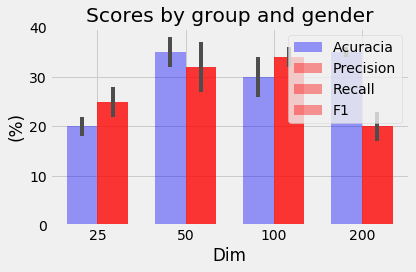

In [18]:
n_groups = 4

means_men = (20, 35, 30, 35)
std_men = (2, 3, 4, 1)

means_women = (25, 32, 34, 20)
std_women = (3, 5, 2, 3)

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = plt.bar(index, means_men, bar_width,
                 alpha=opacity,
                 color='b',
                 yerr=std_men,
                 error_kw=error_config,
                 label='Acuracia')

rects2 = plt.bar(index + bar_width, means_women, bar_width,
                 alpha=opacity,
                 color='r',
                 yerr=std_women,
                 error_kw=error_config,
                 label='Precision')

rects3 = plt.bar(index + bar_width, means_women, bar_width,
                 alpha=opacity,
                 color='r',
                 yerr=std_women,
                 error_kw=error_config,
                 label='Recall')

rects4 = plt.bar(index + bar_width, means_women, bar_width,
                 alpha=opacity,
                 color='r',
                 yerr=std_women,
                 error_kw=error_config,
                 label='F1')

plt.xlabel('Dim')
plt.ylabel('(%)')
plt.title('Scores by group and gender')
plt.xticks(index + bar_width / 2, ('25', '50', '100', '200', 'E'))
plt.legend()

plt.tight_layout()
plt.show()